# Importing and definitions


## Importing

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize #use scipy.optimize for T1 and necessarily pi pulse
from qutip import *
from IPython.display import Image

Our Hamiltonian, including the Kerr non-linearity, the parametric drive and the additional single-photon drive, can be written, in the rotating frame, as:

$$\displaystyle \hat{H} = - K \hat{a}^\dagger\hat{a}^\dagger\hat{a}\hat{a} + \epsilon_2 (a^{\dagger2}+a^2) +\epsilon^*_x\hat{a}^\dagger+\epsilon_x\hat{a}$$



## Definitions

In [2]:
K   = 0.01 # Kerr constant          
eps2    = 0.04 # nonlinear drive strength
t = np.linspace(0, 50000, 1001) # time #note we adjusted the  step sizes  

In [3]:
N=20  # size of the Hilbert space (number of levels in the oscillator we take into account in simulation)
a = destroy(N) #annihilation operator
alpha=np.sqrt(eps2/K) #coherent state amplitude of hamiltonian eigenstate
zp=1/np.sqrt(2*(1+np.exp(-2*np.abs(alpha)**2)))*(coherent(N,alpha)+coherent(N,-alpha)) #|+Z>
zn=1/np.sqrt(2*(1-np.exp(-2*np.abs(alpha)**2)))*(coherent(N,alpha)-coherent(N,-alpha)) #|-Z>
yp=1/np.sqrt(2)*(zp+1j*zn) #|+Y>
yn=1/np.sqrt(2)*(zp-1j*zn) #|-Y>
xp=1/np.sqrt(2)*(zp+zn) #|+X>
xn=1/np.sqrt(2)*(zp-zn) #|-X>

In [4]:
sigma_z=zp*zp.dag()-zn*zn.dag() # |Z> operator in cat basis
sigma_x=zp*zn.dag()+zn*zp.dag() # |X> operator in cat basis
sigma_y=-1j*zp*zn.dag()+1j*zn*zp.dag() # |Y> operator in cat basis
identity=zp*zp.dag()+zn*zn.dag() # Identity operator in cat basis

In [5]:
def Hs(t,t0): #define Heaviside function
    if t<t0:
        return 0
    else:
        return 1
    
def Hpd_coeff(t, args): # defines the coefficient for the parametric drive. It will be rampled up over a time 'tpd'
    tpd=args['tpd']
    return 1-np.exp(-t/tpd) 

def Hspd_coeff(t, args): # defines time window for single photon drive
    t1=args['t1']
    t2=args['t2']
    epsx=1
    if('epsx' in args):
        epsx=args['epsx']
    return epsx*(Hs(t,t1)-Hs(t,t2))

def collapse(kappa,n_th): #find collapse operators given loss kappa and thermal photons n_th
    c_ops  = []
    # cavity relaxation
    rate = kappa * (1 + n_th)
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * a)

    # cavity excitation, if temperature > 0
    rate = kappa * n_th
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * a.dag())
    return c_ops

#redefine qutip plotting functions
def plot_wigner(rho, fig=None, ax=None, figsize=(6, 4),
                cmap=None, alpha_max=7.5, colorbar=True,
                method='clenshaw', projection='2d'):

    if not fig and not ax:
        if projection == '2d':
            fig, ax = plt.subplots(1, 1, figsize=figsize)
        elif projection == '3d':
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(1, 1, 1, projection='3d')
        else:
            raise ValueError('Unexpected value of projection keyword argument')

    if isket(rho):
        rho = ket2dm(rho)

    xvec = np.linspace(-alpha_max, alpha_max, 200)
    W0 = wigner(rho, xvec, xvec, method=method, g=2)

    W, yvec = W0 if isinstance(W0, tuple) else (W0, xvec)

    wlim = abs(W).max()

    if cmap is None:
        cmap = cm.get_cmap('RdBu')

    if projection == '2d':
        cf = ax.contourf(xvec, yvec, W, 100,
                         norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap)
    elif projection == '3d':
        X, Y = np.meshgrid(xvec, xvec)
        cf = ax.plot_surface(X, Y, W0, rstride=5, cstride=5, linewidth=0.5,
                             norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap)
    else:
        raise ValueError('Unexpected value of projection keyword argument.')

    if xvec is not yvec:
        ax.set_ylim(xvec.min(), xvec.max())

    ax.set_xlabel(r'$\rm{Re}(\beta)$', fontsize=12)
    ax.set_ylabel(r'$\rm{Im}(\beta)$', fontsize=12)

    if colorbar:
        fig.colorbar(cf, ax=ax)

    ax.set_title("Wigner function", fontsize=12)

    return fig, ax

def plot_wigner_fock_distribution(rho, fig=None, axes=None, figsize=(8, 3),
                                  cmap='seismic', alpha_max=3.5, colorbar=True,
                                  method='iterative', projection='2d'):

    if not fig and not axes:
        if projection == '2d':
            fig, axes = plt.subplots(1, 2, figsize=figsize)
        elif projection == '3d':
            fig = plt.figure(figsize=figsize)
            axes = [fig.add_subplot(1, 2, 1),
                    fig.add_subplot(1, 2, 2, projection='3d')]
        else:
            raise ValueError('Unexpected value of projection keyword argument')

    if isket(rho):
        rho = ket2dm(rho)

    plot_fock_distribution(rho, fig=fig, ax=axes[0])
    plot_wigner(rho, fig=fig, ax=axes[1], figsize=figsize, cmap=cmap,
                alpha_max=alpha_max, colorbar=colorbar, method=method,
                projection=projection)

    return fig, axes

# Code

## Ramping up states

In [6]:
c_ops=[] #empty for now
tpd = 10000 #ramping time for the parametric drive
Hnl= -K*a.dag() * a.dag() * a * a  #non linear hamiltonian
Hpd = eps2 * (a.dag() * a.dag() + a * a) # parametric drive hamiltonian
H = [Hnl,[Hpd,Hpd_coeff]] #non linear hamiltonian + parametric drive hamiltonian multiplied by the ramping
options = Options(nsteps=np.max(t)) #options for not letting it fail

### Initial state $|\psi\rangle=|0\rangle $

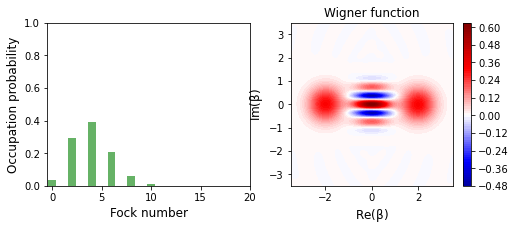

In [7]:
psi0 = basis(N,0)  #initial state
result = mesolve(H, psi0, t, c_ops, [], args={'tpd':tpd}, options=options) #master equation solver
plot_wigner_fock_distribution(result.states[-1]) #plotting
plt.show()

2a)

We want to know the steady state after the evolution. From the first graph, we can see the occupation probability. It becomes clear, that for the steady state (which is plotted, by indexing -1 from the results.states), only even Fock states are occupied. We can therefore assume that our steady state will be the schrödinger cat-like superposition of the coherent states alpha, with even photon number parity, namely $|C_{\alpha}^+\rangle$  ($= |+X\rangle$ with the notation from below).

As we have shown in previous exercises, the cat states are Eigenstates of this Hamiltonian. Since we start here with an even photon number parity, it makes sense, that the Hamiltonian will evolve the state into a steady state with the same property of having even parity.
Furthermore, if we look at the Hamiltonian, we only have squares of the creation and or annihilation operator, which means, that not only the steady state, but also all states within this evolution will have the same parity as the initial state.

### Initial state $|\psi\rangle=|1\rangle $

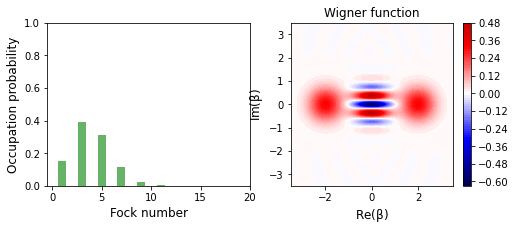

In [8]:
psi0 = basis(N,1) #initial state
result = mesolve(H, psi0, t, c_ops, [], args={'tpd':tpd}, options=options) #master equation solver
plot_wigner_fock_distribution(result.states[-1]) #plotting
plt.show()

2a) continued

Here, only odd Fock states are populated. We can therefore assume that our steady state will be the schrödinger cat-like superposition of alpha, with even photon number parity, namely $|C_{\alpha}^-\rangle$  ($= |-X\rangle$ with the notation from below) .

The same argumentation as before, also holds true for the 1-state. We have an odd photon number parity, therefore the Hamiltonian will evolve the state into a steady state with odd photon number parity

### Initial state $|\psi\rangle=\frac{1}{\sqrt(2)}(|0\rangle+|1\rangle) $

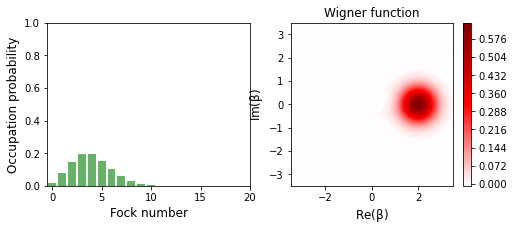

In [9]:
psi0 = 1/np.sqrt(2)* (basis(N,0)+basis(N,1)) #initial state
result = mesolve(H, psi0, t, c_ops, [], args={'tpd':tpd}, options=options) #master equation solver
plot_wigner_fock_distribution(result.states[-1]) #plotting
plt.show()

Here, we can see, that we no longer have a photon number parity, but instead some kind of gaussian distribution. The Wigner function is always positive, which corresponds to some sort of classical state (as described in the lecture). 
Based of the previous exercise, we could have expected a superposition of the cat states. Since they have the same weight, we would assume, that the -alpha term cancels out, leaving behind only the coherent state |+alpha> which is of course also an eigenstate of the Hamiltonian.
The state corresponds to the $|+Z\rangle$-state, with notation from below. 

### Initial state $|\psi\rangle=\frac{1}{\sqrt(2)}(|0\rangle+i|1\rangle) $

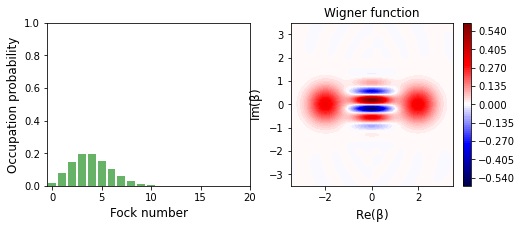

In [10]:
psi0 = 1/np.sqrt(2)* (basis(N,0)+1j*basis(N,1)) #initial state
result = mesolve(H, psi0, t, c_ops, [], args={'tpd':tpd}, options=options) #master equation solver
plot_wigner_fock_distribution(result.states[-1]) #plotting
plt.show()

Again, we could have expected a superposition of the cat states, but with an additional complex factor for the |c_alpha_-> state.
The resulting state would therefore corerspond to a normalisation constant times  $|+alpha>+|-alpha\rangle+i*|+alpha\rangle-i*|-alpha\rangle$, which would be a superposition of all 4 states that we discussed in the lecture for the phase space.

In terms of the cat-bloch-sphere (with the naming convention from the paper "Bias-preserving gates with stabilized cat qubits", Shruti Puri et. al., see picture below, the state $|\psi\rangle=\frac{1}{\sqrt(2)}(|0\rangle+|1\rangle) $ will evolve into the $|+Z\rangle$ state on the cat bloch sphere
whereas $|\psi\rangle=\frac{1}{\sqrt(2)}(|0\rangle+i|1\rangle) $ will evolve into $|+Y\rangle$ state on the cat Bloch sphere

Please note, that this naming convention does not necessarily match the Basis descriptions of sigma x sigma y and sigma z for the following exercises.
We note, that it makes sense, that all orthogonal states in our regular Basis, will be evolved into their counterart on the Cat-sphere.

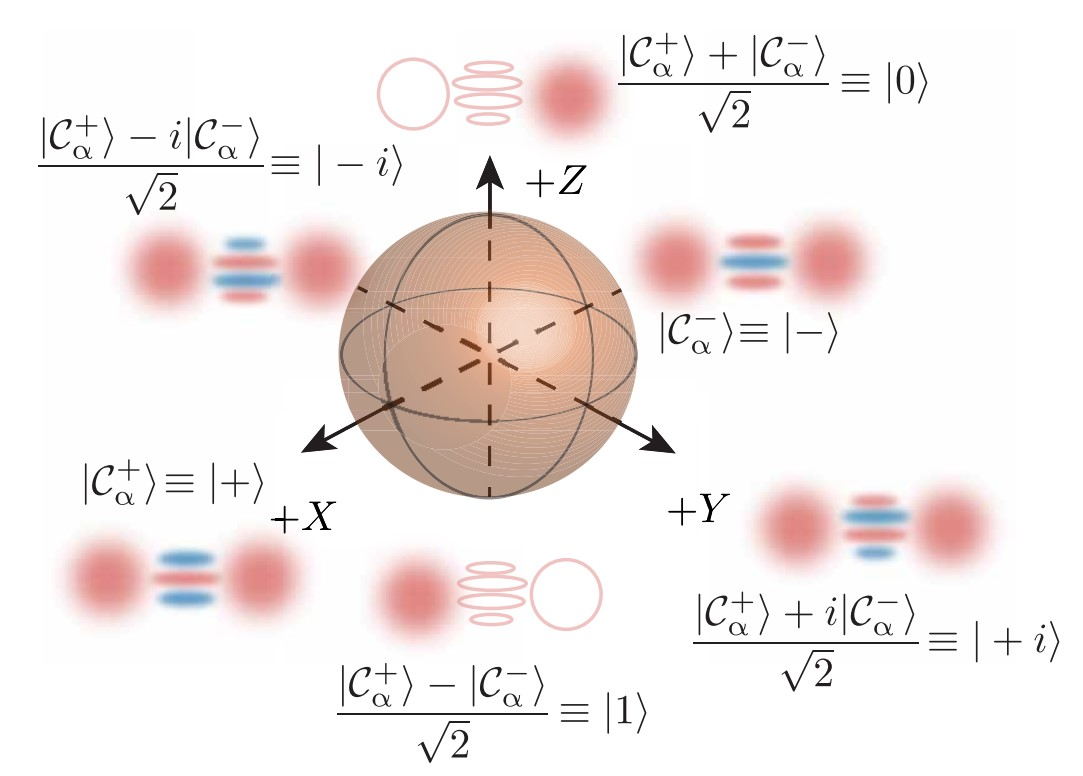


## Adding the drive term

### Drive phase $\pi$

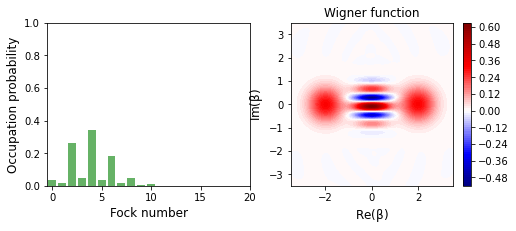

In [11]:
theta =np.pi #phase of the single photon drive
amp=0.001 #amplitude of the single photon drive
epsx    = amp*np.exp(1j*theta) #coefficient of the single photon drive 
t1 = 15000 #final time single photon drive                        
t2 = 14000 #initial time single photon drive  
Hspd = np.conjugate(epsx) * a.dag()  + epsx * a #hamiltonian single photon drive  
H = [Hnl,[Hpd,Hpd_coeff],[Hspd,Hspd_coeff]] #full hamiltonian with some coefficients
psi0 = basis(N,0) #initial state
result = mesolve(H, psi0, t, c_ops, [], args={'tpd':tpd,'t1':t1,'t2':t2}, options=options) #master equation solver
plot_wigner_fock_distribution(result.states[-1]) #plotting
plt.show()

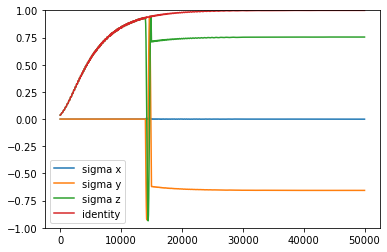

In [12]:
#Plot Pauli matrices over time
plt.figure()
result = mesolve(H, psi0, t, c_ops, [sigma_x,sigma_y,sigma_z,identity], args={'tpd':tpd,'t1':t1,'t2':t2}, options=options)
plt.plot(t,result.expect[0],label='sigma x')
plt.plot(t,result.expect[1],label='sigma y')
plt.plot(t,result.expect[2],label='sigma z')
plt.plot(t,result.expect[3],label='identity')
plt.ylim(-1,1)
plt.legend()
plt.show()

Zoom in on the interesting region:

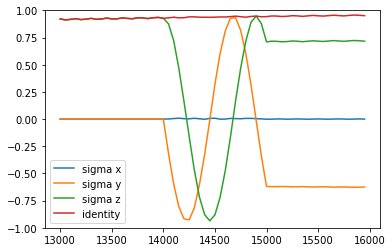

In [13]:
plt.figure()
result = mesolve(H, psi0, t, c_ops, [sigma_x,sigma_y,sigma_z,identity], args={'tpd':tpd,'t1':t1,'t2':t2}, options=options)
plt.plot(t[260:320],result.expect[0][260:320],label='sigma x')
plt.plot(t[260:320],result.expect[1][260:320],label='sigma y')
plt.plot(t[260:320],result.expect[2][260:320],label='sigma z')
plt.plot(t[260:320],result.expect[3][260:320],label='identity')
plt.ylim(-1,1)
plt.legend()
plt.show()

During the time-frame where we apply the drive pulse, we can clearly see, how the expectation value for x does not change (at least not significantly in comparison to the expectation value of sigma y or sigma z). We can therefore deduce, that the action of the drive hamiltonian on the qubit causes rotations around the x-axis. 

Since the expectation value for x also remains constantly near 0, we can deduce, that we remain in the y-z-plane, whereas our starting point is (close to) |+Z> 

#### Find pi pulse

A pi pulse should now bring us from the |+Z> to the |-Z> state. We can see that this is the case for a drive pulse time of around 450ns (assuming that the unit we are using is ns).
In order to find the precise pulse time, we can calculate the minimum of the expectation value for Z from the last exercise, as seen below.


In [14]:
timestamp = np.argmin(result.expect[2][260:320])
timeprecise = t[289]-14000
print(timeprecise)

450.0


We can see, that our estimate was actually exact (within an error range of +-25 due to our step-size in time of 50). Now to implement our pi-pulse, we can just change the values from the last exercise and repeat.

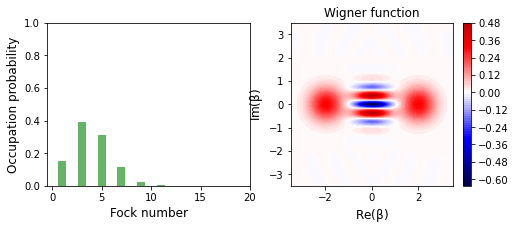

In [15]:
theta =np.pi #phase of the single photon drive
amp=0.001 #amplitude of the single photon drive
epsx    = amp*np.exp(1j*theta) #coefficient of the single photon drive 
t1 = 14450 #final time single photon drive  <---- We changed the final time here                       
t2 = 14000 #initial time single photon drive  
Hspd = np.conjugate(epsx) * a.dag()  + epsx * a #hamiltonian single photon drive  
H = [Hnl,[Hpd,Hpd_coeff],[Hspd,Hspd_coeff]] #full hamiltonian with some coefficients
psi0 = basis(N,0) #initial state
result = mesolve(H, psi0, t, c_ops, [], args={'tpd':tpd,'t1':t1,'t2':t2}, options=options) #master equation solver
plot_wigner_fock_distribution(result.states[-1]) #plotting
plt.show()

We can see that this worked very well.

### Drive phase $\pi/2$

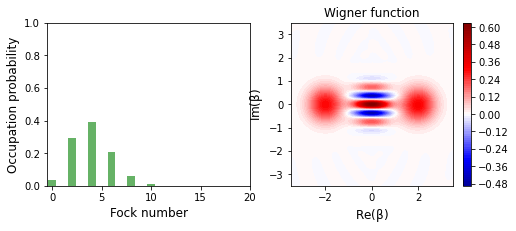

In [16]:
theta =np.pi/2 #phase of the single photon drive
amp=0.001 #amplitude of the single photon drive
epsx    = amp*np.exp(1j*theta) #coefficient of the single photon drive 
t1 = 15000 #final time single photon drive                        
t2 = 14000 #initial time single photon drive     
Hspd = np.conjugate(epsx) * a.dag()  + epsx * a #hamiltonian single photon drive 
H = [Hnl,[Hpd,Hpd_coeff],[Hspd,Hspd_coeff]] #full hamiltonian with some coefficients
psi0 = basis(N,0) #initial state
result = mesolve(H, psi0, t, c_ops, [], args={'tpd':tpd,'t1':t1,'t2':t2}, options=options) #master equation solver
plot_wigner_fock_distribution(result.states[-1]) #plotting
plt.show()

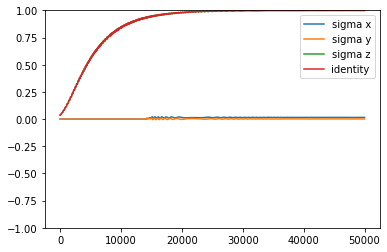

In [17]:
#Plot Pauli matrices over time
plt.figure()
result = mesolve(H, psi0, t, c_ops, [sigma_x,sigma_y,sigma_z,identity], args={'tpd':tpd,'t1':t1,'t2':t2}, options=options)
plt.plot(t,result.expect[0],label='sigma x')
plt.plot(t,result.expect[1],label='sigma y')
plt.plot(t,result.expect[2],label='sigma z')
plt.plot(t,result.expect[3],label='identity')
plt.ylim(-1,1)
plt.legend()
plt.show()

Here we can see, that the drive has almost no effect on any expectation value. For a comparison with the result of Exercise 1i), we would need to calculate first the Rabi Frquency.

In [18]:
#theta = pi/2
omega = 4*np.real(epsx*alpha)
print(omega)


4.898587196589413e-19


In [19]:
#theta = pi
print(4*np.real(0.001*np.exp(1j*np.pi)*alpha))


-0.008


This explains, why we dont see much of a change, since our Oscillation frequency is basically 0 in the case where we phase-shift our pulse.

### Increasing the drive strength

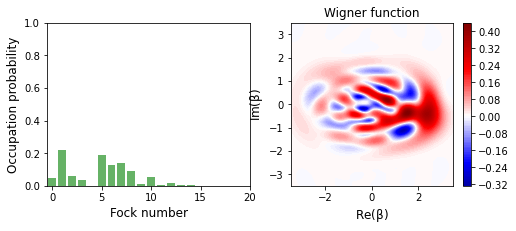

In [20]:
theta =np.pi #phase of the single photon drive
amp=0.1 #amplitude of the single photon drive
epsx    = amp*np.exp(1j*theta) #coefficient of the single photon drive 
t1 = 15000 #final time single photon drive                        
t2 = 14000 #initial time single photon drive     
Hspd = np.conjugate(epsx) * a.dag()  + epsx * a #hamiltonian single photon drive 
H = [Hnl,[Hpd,Hpd_coeff],[Hspd,Hspd_coeff]] #full hamiltonian with some coefficients
psi0 = basis(N,0) #initial state
result = mesolve(H, psi0, t, c_ops, [], args={'tpd':tpd,'t1':t1,'t2':t2}, options=options) #master equation solver
plot_wigner_fock_distribution(result.states[-1]) #plotting
plt.show()

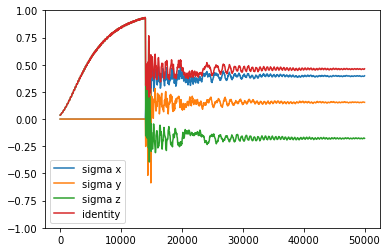

In [21]:
#Plot Pauli matrices over time
plt.figure()
result = mesolve(H, psi0, t, c_ops, [sigma_x,sigma_y,sigma_z,identity], args={'tpd':tpd,'t1':t1,'t2':t2}, options=options)
plt.plot(t,result.expect[0],label='sigma x')
plt.plot(t,result.expect[1],label='sigma y')
plt.plot(t,result.expect[2],label='sigma z')
plt.plot(t,result.expect[3],label='identity')
plt.ylim(-1,1)
plt.legend()
plt.show()

Now, with a much larger Amplitude of the single photon drive, we can see, that some kind of steady state is reached, however it does no longer lie on the Bloch Sphere (since the expectation value of the identity operator is no longer +1). Therefore we are also no longer in a Coherent state, since we have driven the system too hard.

We can imagine it, as though we are no longer driving first order transitions, but also second order transitions (which would require a higher Energy given now by the larger Amplitude of the drive).

## Free evolution from $|\alpha\rangle$

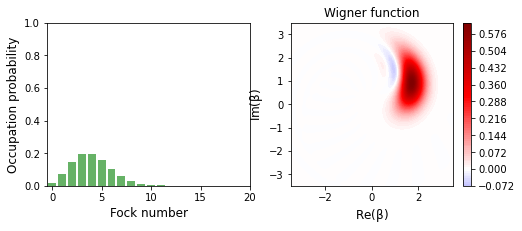

In [22]:
alpha=2
psi0=coherent(N,2)
H = [Hnl]
c_ops=[]
t=np.linspace(0,np.pi/50/K,1000)
result = mesolve(H, psi0, t, c_ops, [])
plot_wigner_fock_distribution(result.states[-1])
plt.show()

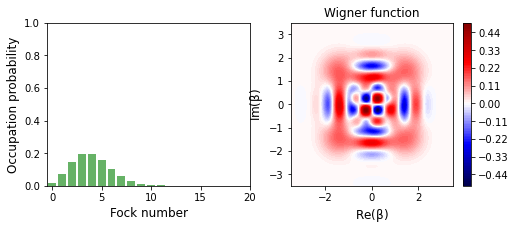

In [23]:
alpha=2
psi0=coherent(N,2)
H = [Hnl]
c_ops=[]
t=np.linspace(0,np.pi/4/K,1000)
result = mesolve(H, psi0, t, c_ops, [], options=options)
plot_wigner_fock_distribution(result.states[-1])
plt.show()

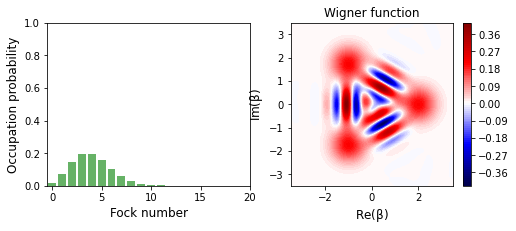

In [24]:
alpha=2
psi0=coherent(N,2)
H = [Hnl]
c_ops=[]
t=np.linspace(0,np.pi/3/K,1000)
result = mesolve(H, psi0, t, c_ops, [], options=options)
plot_wigner_fock_distribution(result.states[-1])
plt.show()

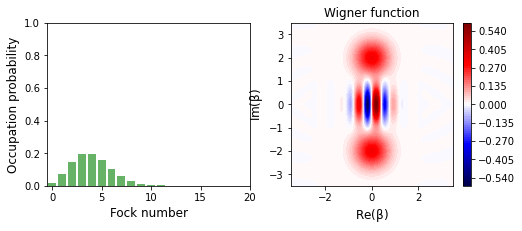

In [25]:
alpha=2
psi0=coherent(N,2)
H = [Hnl]
c_ops=[]
t=np.linspace(0,np.pi/2/K,1000)
result = mesolve(H, psi0, t, c_ops, [], options=options)
plot_wigner_fock_distribution(result.states[-1])
plt.show()

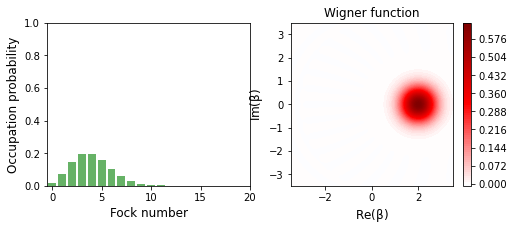

In [26]:
alpha=2
psi0=coherent(N,2)
H = [Hnl]
c_ops=[]
t=np.linspace(0,np.pi/K,1000)
result = mesolve(H, psi0, t, c_ops, [], options=options)
plot_wigner_fock_distribution(result.states[-1])
plt.show()

Here, we limited ourselves to the Hamiltonian Hnl= -K*a.dag() * a.dag() * a * a 

We can see, that for any evolution time, the occupation probability of the Fock-states remains the same. We can see, however, a massive shift in the Wigner function, and for pi/K, we land exactly again in our starting state.

For further interpretations, we are helping ourselves with the paper 'Wigner function evolution of quantum states in the presence of self-Kerr interaction' PHYSICAL REVIEW A 78, 013810 (2008), Magdalena Stobińska et al. https://journals.aps.org/pra/pdf/10.1103/PhysRevA.78.013810 .

For time t = 0 or t = pi/k the Wigner function is Gaussian (coherent state), which makes sense since we start with a coherent state and the Hamiltonian is periodic. 

For small t's (here pi/50k), the Wigner function becomes squeezed and the negative values start appearing. This can be explained via the Hamiltonian (see paper) which leads to the fact that photons with stronger amplitude are acquiring phase faster than the photons with smaller amplitude, which leads to the rotation and squeezing.

If we further increase t, we can see interference patterns arising (i.e pi/4k, which corresponds to a superposition of 4 coherent states) and for pi/3k we will get a coherent superposition state of 3 coherent states.

For a pi/2K evolution we we reach an orthogonal Cat, which differes by a global phase as compared to the cat states discussed before. 

This means that we can bring a Cat state to an orthogonal Cat state, with a global phase given by the free evolution (whereas before it was given by our drive).

Thus, we can implement a pi/2 pulse around an axis defined by the free evolution, which can be implemented as a Gate.

We note, that for evolution time equal to a fraction of pi, we will end up in a superposition state. This is apparently also known as fractional revival.

## Added losses

In [27]:
kappa=0.00005 #loss kappa
n_th=0.00 #thermal photons
c_ops=collapse(kappa,n_th)

### State $|+Z\rangle$

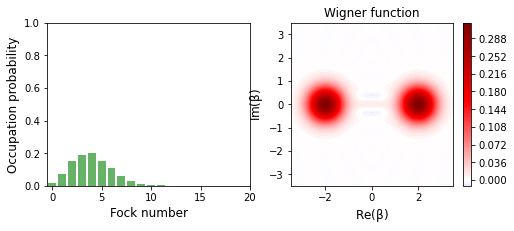

In [28]:
psi0=zp
H=[Hnl+Hpd]
t=np.linspace(0,10000,101)
result = mesolve(H, psi0, t, c_ops, [],args={'tpd':tpd},options=options)
plot_wigner_fock_distribution(result.states[-1])
plt.show()

As discussed in the lecture, the losses will lead to a "broadening" of the Wigner function in this Amplitude related phase space. Whereas photon-loss would cause the Wigner function to "move" towards the origin of the phase space, dephasing would cause "movements" along the circle spanned by the cat states. Here we see, that we are basically in a superposition of |+-alpha>. Now it would be interesting to have the direct comparison to psi0:

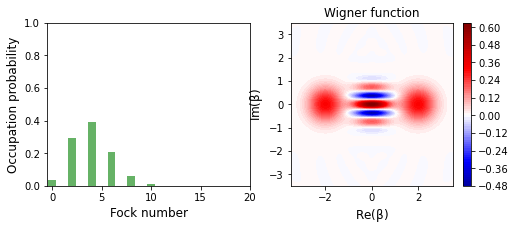

In [29]:
plot_wigner_fock_distribution(psi0)
plt.show()

We can definitely see, how the Wigner function has broadened due to the losses, and how the parity has almost completely vanished. We can conclude, that the losses are mainly due to dephasing.

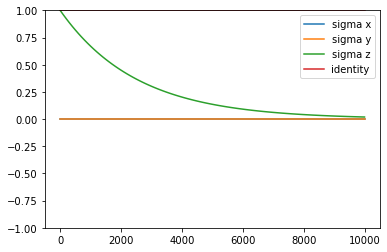

In [30]:
plt.figure()
result = mesolve(H, psi0, t, c_ops, [sigma_x,sigma_y,sigma_z,identity], args={'tpd':tpd}, options=options)
plt.plot(t,result.expect[0],label='sigma x')
plt.plot(t,result.expect[1],label='sigma y')
plt.plot(t,result.expect[2],label='sigma z')
plt.plot(t,result.expect[3],label='identity')
plt.ylim(-1,1)
plt.legend()
plt.show()

#### Finding $T_1$

From the plot above, we can estimate that T1 (i.e. the time until the expecation value of sigma z has reached around 63%, is 1000ns = 1mus. We can again try to find the exact time T1:


In [31]:
index = 0
for i in result.expect[2]:
    if i < 0.63:
        print(index)
        break
    index = index + 1
    

12


We can conclude, that T1 is 1200ns +- 50 ns

### State $|+X\rangle$

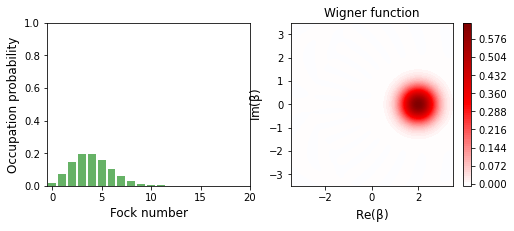

In [32]:
psi0=xp
H=[Hnl+Hpd]
t=np.linspace(0,10000,101)
result = mesolve(H, psi0, t, c_ops, [],args={'tpd':tpd},options=options)
plot_wigner_fock_distribution(result.states[-1])
plt.show()

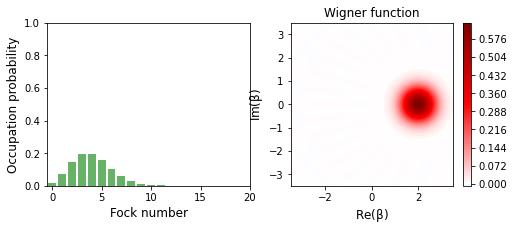

In [33]:
plot_wigner_fock_distribution(psi0)
plt.show()

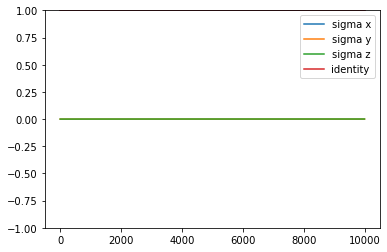

In [34]:
plt.figure()
result = mesolve(H, psi0, t, c_ops, [sigma_x,sigma_y,sigma_z,identity], args={'tpd':tpd}, options=options)
plt.plot(t,result.expect[0],label='sigma x')
plt.plot(t,result.expect[1],label='sigma y')
plt.plot(t,result.expect[2],label='sigma z')
plt.plot(t,result.expect[3],label='identity')
plt.ylim(-1,1)
plt.legend()
plt.show()

We can see, that the X-State is not affected by the losses added to the Hamiltonian.

### State $|+Y\rangle$

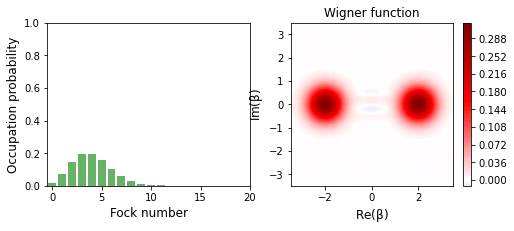

In [35]:
psi0=yp
H=[Hnl+Hpd]
t=np.linspace(0,10000,101)
result = mesolve(H, psi0, t, c_ops, [],args={'tpd':tpd},options=options)
plot_wigner_fock_distribution(result.states[-1])
plt.show()

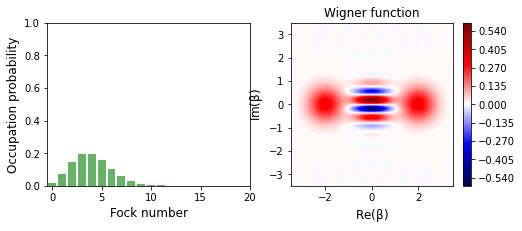

In [36]:
plot_wigner_fock_distribution(psi0)
plt.show()

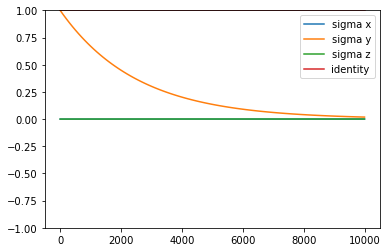

In [37]:
plt.figure()
result = mesolve(H, psi0, t, c_ops, [sigma_x,sigma_y,sigma_z,identity], args={'tpd':tpd}, options=options)
plt.plot(t,result.expect[0],label='sigma x')
plt.plot(t,result.expect[1],label='sigma y')
plt.plot(t,result.expect[2],label='sigma z')
plt.plot(t,result.expect[3],label='identity')
plt.ylim(-1,1)
plt.legend()
plt.show()

The Same Behaviour and argumentation as for the Z-state. We can now conclude that with these losses, the depasing will mainly happen around the X-axis (i.e parallel to the y-Z plane).